In [34]:
import os
import sys
import keras
import tarfile
import numpy as np
import tensorflow as tf
import urllib.request as urllib
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.engine.training import Model
from keras import backend as K, regularizers
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Add, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
# Help from http://165.132.29.26/upfiles/15159371917373.pdf

from PIL import Image
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = '/content/gdrive/My Drive/Temp/Whether/dataset'
categories = sorted(os.listdir(caltech_dir))
nb_classes = len(categories)

X = []
Y = []
image_w = 64
image_h = 64

for idx, f in enumerate(categories):
    label = [0 for i in range(nb_classes)] 
    label[idx] = 1
    image_dir = caltech_dir + "/" + f 
    files = glob.glob(image_dir + "/*.jpg")

    for i, fname in enumerate(files):
        img = Image.open(fname)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)
        X.append(data)
        Y.append(label)
          
for ang in range(-20, 20, 5):
    img2 = img.rotate(ang)
    data = np.asarray(img2) 
    X.append(data)
    Y.append(label)

    img2 = img2.transpose(Image.FLIP_LEFT_RIGHT)
    data = np.asarray(img2) 
    X.append(data)
    Y.append(label)

In [37]:
X = np.array(X)
Y = np.array(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [38]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [39]:
print('X_train shape: ', x_train.shape[0])
print('Y_train shape: ', y_train.shape)

X_train shape:  1973
Y_train shape:  (1973, 7)


Train: X=(1973, 64, 64, 3), y=(1973, 7)
Test: X=(658, 64, 64, 3), y=(658, 7)


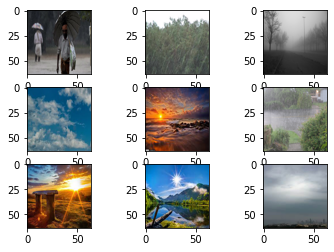

In [40]:
from matplotlib import pyplot

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)

	# plot raw pixel data
	pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))

# show the figure
pyplot.show()

In [41]:
# applying transformation to image
train_gen = ImageDataGenerator(
        rotation_range=20,  
        zoom_range = 0.15,  
        width_shift_range=0.5, 
        height_shift_range=0.5,
        brightness_range=[0.25,1.5],
        horizontal_flip=True,
)

# test_gen = ImageDataGenerator()
train_gen.fit(x_train)

test_set = train_gen.flow(x_test, y_test, batch_size=256)

In [53]:
model = Sequential()

# Block 1
model.add(Conv2D(32, kernel_size=3, kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), padding='same', input_shape=(64, 64, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Block 2
model.add(Conv2D(64, kernel_size=3, kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(2, 2))

# Block 3
model.add(Conv2D(128, kernel_size=3, kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Block 4
model.add(Conv2D(256, kernel_size=3, kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(2, 2))

# Block 5
model.add(Conv2D(512, kernel_size=3, kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Block 6
model.add(Conv2D(1024, kernel_size=3, kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(2, 2))

model.add(Flatten())

# Dense 1
model.add(Dense(1400, kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Dense 2
model.add(Dense(7, kernel_regularizer=l2(0.0005), activation='softmax'))

# Visualize Model
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_52 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_53 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 32, 32, 64)       

In [54]:
initial_lr = 1e-2

def lr_scheduler(epoch):
    if epoch < 20:
        return initial_lr
    elif epoch < 40:
        return initial_lr / 20
    elif epoch < 50:
        return initial_lr / 40
    elif epoch < 60:
        return initial_lr / 80
    elif epoch < 70:
        return initial_lr / 160
    elif epoch < 80:
        return initial_lr / 320
    elif epoch < 90:
        return initial_lr / 640
    else:
        return initial_lr / 1280

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(initial_lr),
    metrics = ['accuracy']
)

In [55]:
history = model.fit(
  x_train, y_train,
  epochs=300,
  verbose=1,
  validation_data=(x_test, y_test),
  callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
  shuffle=True
)

Epoch 1/300
62/62 [==============================] - 9s 151ms/step - loss: 81.4254 - accuracy: 0.5854 - val_loss: 83.7932 - val_accuracy: 0.4529
Epoch 2/300
62/62 [==============================] - 9s 146ms/step - loss: 32.9128 - accuracy: 0.6954 - val_loss: 18.7740 - val_accuracy: 0.6444
Epoch 3/300
62/62 [==============================] - 9s 146ms/step - loss: 13.6594 - accuracy: 0.7329 - val_loss: 11.4970 - val_accuracy: 0.4331
Epoch 4/300
62/62 [==============================] - 9s 145ms/step - loss: 8.1409 - accuracy: 0.7572 - val_loss: 7.4544 - val_accuracy: 0.5198
Epoch 5/300
62/62 [==============================] - 9s 145ms/step - loss: 5.6500 - accuracy: 0.7886 - val_loss: 5.4986 - val_accuracy: 0.3480
Epoch 6/300
62/62 [==============================] - 9s 146ms/step - loss: 4.6744 - accuracy: 0.7542 - val_loss: 5.3514 - val_accuracy: 0.4453
Epoch 7/300
62/62 [==============================] - 9s 146ms/step - loss: 3.7323 - accuracy: 0.7876 - val_loss: 4.0002 - val_accuracy: 

KeyboardInterrupt: ignored

Test loss: 0.3987545371055603 / Test accuracy: 94.52887773513794


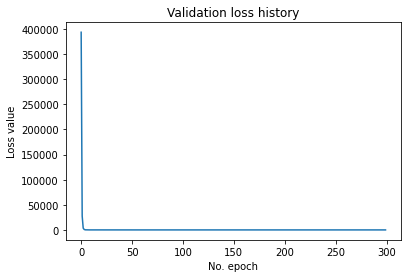

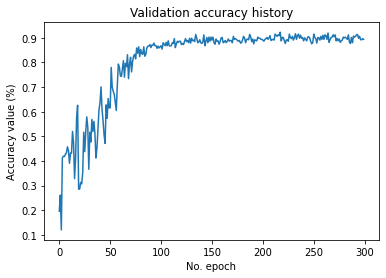

In [56]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]*100}')

# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

In [61]:
initial_lr = 1e-6

def lr_scheduler(epoch):
    if epoch < 20:
        return initial_lr /10
    elif epoch < 40:
        return initial_lr / 20
    elif epoch < 50:
        return initial_lr / 40
    elif epoch < 60:
        return initial_lr / 80
    elif epoch < 70:
        return initial_lr / 160
    elif epoch < 80:
        return initial_lr / 320
    elif epoch < 90:
        return initial_lr / 640
    else:
        return initial_lr / 1280

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(initial_lr),
    metrics = ['accuracy']
)

In [62]:
history = model.fit(
  x_train, y_train,
  epochs=125,
  verbose=1,
  validation_data=(x_test, y_test),
  callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
  shuffle=True
)

Epoch 1/125
62/62 [==============================] - 9s 151ms/step - loss: 0.1147 - accuracy: 0.9970 - val_loss: 0.3693 - val_accuracy: 0.9483
Epoch 2/125
62/62 [==============================] - 9s 147ms/step - loss: 0.1120 - accuracy: 0.9980 - val_loss: 0.3692 - val_accuracy: 0.9483
Epoch 3/125
62/62 [==============================] - 9s 147ms/step - loss: 0.1116 - accuracy: 0.9980 - val_loss: 0.3687 - val_accuracy: 0.9468
Epoch 4/125
62/62 [==============================] - 9s 147ms/step - loss: 0.1120 - accuracy: 0.9980 - val_loss: 0.3687 - val_accuracy: 0.9468
Epoch 5/125
62/62 [==============================] - 9s 147ms/step - loss: 0.1127 - accuracy: 0.9965 - val_loss: 0.3701 - val_accuracy: 0.9468
Epoch 6/125
62/62 [==============================] - 9s 146ms/step - loss: 0.1117 - accuracy: 0.9975 - val_loss: 0.3698 - val_accuracy: 0.9468
Epoch 7/125
62/62 [==============================] - 9s 146ms/step - loss: 0.1109 - accuracy: 0.9975 - val_loss: 0.3694 - val_accuracy: 0.9468

Test loss: 0.3674013316631317 / Test accuracy: 94.83282566070557


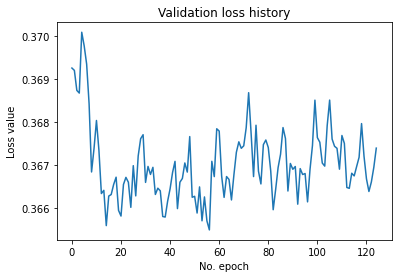

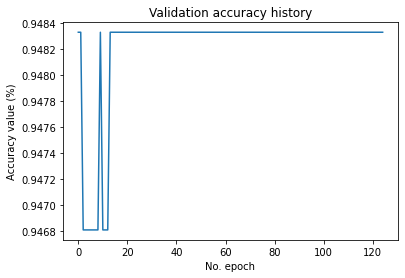

In [64]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]*100}')

# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

In [74]:
initial_lr = 1e-4

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(initial_lr),
    metrics = ['accuracy']
)

In [75]:
history = model.fit(
  x_train, y_train,
  epochs=25,
  verbose=1,
  validation_data=(x_test, y_test),
  callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
  shuffle=True
)

Epoch 1/25
62/62 [==============================] - 9s 151ms/step - loss: 0.1102 - accuracy: 0.9954 - val_loss: 0.3473 - val_accuracy: 0.9483
Epoch 2/25
62/62 [==============================] - 9s 146ms/step - loss: 0.1055 - accuracy: 0.9970 - val_loss: 0.3544 - val_accuracy: 0.9453
Epoch 3/25
62/62 [==============================] - 9s 147ms/step - loss: 0.1068 - accuracy: 0.9959 - val_loss: 0.3627 - val_accuracy: 0.9453
Epoch 4/25
62/62 [==============================] - 9s 147ms/step - loss: 0.1065 - accuracy: 0.9970 - val_loss: 0.3699 - val_accuracy: 0.9453
Epoch 5/25
62/62 [==============================] - 9s 147ms/step - loss: 0.1059 - accuracy: 0.9965 - val_loss: 0.3475 - val_accuracy: 0.9468
Epoch 6/25
62/62 [==============================] - 9s 147ms/step - loss: 0.1081 - accuracy: 0.9949 - val_loss: 0.3751 - val_accuracy: 0.9422
Epoch 7/25
62/62 [==============================] - 9s 147ms/step - loss: 0.1067 - accuracy: 0.9954 - val_loss: 0.3407 - val_accuracy: 0.9438
Epoch 